<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_MultiTask_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, timedelta

In [ ]:
TRAIN_DS_START = date(2019,2,15)
TRAIN_DS_END = date(2019,3,15)
VALIDATE_DS_START = date(2019,3,16)
VALIDATE_DS_END = date(2019,3,23)

NUM_PREVIOUS_DAYS = 1

In [783]:
# add daily sum and time bucket ratio to daily sum as features
NUM_TIME_BUCKETS = 96
START_INDEX_FEATURES = NUM_TIME_BUCKETS

def data_preprocess(df, level, train_ds_end = None):
  df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
  df['Date'] = pd.to_datetime(df['Date']).dt.date

  # Normalize data
  if level == 3: # normalized by each node
    df = df.set_index(['Id'])

    df_groupby = df[df['Date'] <= train_ds_end].drop(columns=['Date']).groupby(['Id'])
    df_max = df_groupby.max()+1
    df_min = df_groupby.min()-1
    df = df.join(df_max, rsuffix='_max').join(df_min, rsuffix='_min').reset_index()
    for i in range(1, NUM_TIME_BUCKETS+1):
      df[f'TB{i}'] = (df[f'TB{i}'] - df[f'TB{i}_min']) / (df[f'TB{i}_max'] - df[f'TB{i}_min'])
  else: # normalized globally
    df_max = df.iloc[:,2:].max()+1
    df_min = df.iloc[:,2:].min()-1
    for i in range(1, NUM_TIME_BUCKETS+1):
      df[f'TB{i}'] = (df[f'TB{i}'] - df_min[f'TB{i}']) / (df_max[f'TB{i}'] - df_min[f'TB{i}'])

  # Add daily sum features and time bucket ratio to daily sum
  df['Day_Sum'] = df.apply(lambda row: np.sum(row[2:NUM_TIME_BUCKETS+2]) / NUM_TIME_BUCKETS, axis=1)
  for i in range(1, NUM_TIME_BUCKETS+1):
    df[f'TB{i}_Ratio'] = df.apply(lambda row: row[f'TB{i}'] / row['Day_Sum'], axis=1)

  if level == 3:
    global START_INDEX_FEATURES
    START_INDEX_FEATURES = df.shape[1] - 2

  return df

def data_shift_days(df, days_delta):
  df['Date'] = df['Date'] + pd.Timedelta(days=days_delta)
  return df

In [ ]:
# uploaded1 = files.upload()

In [784]:
df_l1 = pd.read_csv(io.BytesIO(uploaded1['131151000000000965.csv']), header=None)
df_l1 = data_preprocess(df_l1, 1).drop(columns=['Id'])
df_l1

,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,TB39,...,TB57_Ratio,TB58_Ratio,TB59_Ratio,TB60_Ratio,TB61_Ratio,TB62_Ratio,TB63_Ratio,TB64_Ratio,TB65_Ratio,TB66_Ratio,TB67_Ratio,TB68_Ratio,TB69_Ratio,TB70_Ratio,TB71_Ratio,TB72_Ratio,TB73_Ratio,TB74_Ratio,TB75_Ratio,TB76_Ratio,TB77_Ratio,TB78_Ratio,TB79_Ratio,TB80_Ratio,TB81_Ratio,TB82_Ratio,TB83_Ratio,TB84_Ratio,TB85_Ratio,TB86_Ratio,TB87_Ratio,TB88_Ratio,TB89_Ratio,TB90_Ratio,TB91_Ratio,TB92_Ratio,TB93_Ratio,TB94_Ratio,TB95_Ratio,TB96_Ratio
0,2019-01-01,0.045977,0.046655,0.044973,0.038875,0.032231,0.042813,0.047742,0.038987,0.037225,0.032163,0.044017,0.040179,0.031431,0.053578,0.035367,0.041429,0.045765,0.037578,0.041816,0.039492,0.037880,0.041314,0.047070,0.042615,0.041902,0.051098,0.040790,0.047496,0.051427,0.035981,0.036853,0.040062,0.037855,0.052617,0.049928,0.040690,0.044496,0.041735,0.047428,...,0.924832,1.110549,1.092259,0.869614,0.884048,0.954517,1.086444,1.226552,1.064948,0.955812,0.879484,0.917629,1.002092,1.108695,1.242709,0.887010,0.801966,1.013014,1.022812,1.259499,1.032802,0.979452,1.132037,0.990478,0.968695,0.930443,0.955102,0.880361,0.875177,1.278957,1.184144,0.971507,0.948694,0.938203,0.890603,0.860943,0.941671,0.923965,0.861077,0.936521
1,2019-01-02,0.043464,0.026280,0.026341,0.037036,0.028955,0.034504,0.036583,0.024640,0.033617,0.024754,0.033430,0.034279,0.026437,0.032222,0.026924,0.026857,0.032885,0.028006,0.035151,0.039615,0.021809,0.029030,0.034788,0.032623,0.033835,0.036995,0.032986,0.040366,0.038196,0.026231,0.025657,0.036887,0.034217,0.043798,0.038712,0.028969,0.033293,0.031887,0.045952,...,1.055089,1.113452,1.142321,1.097770,1.162534,0.843842,0.992792,1.280471,1.170392,0.884622,0.754611,0.955966,0.878105,0.985370,1.321304,1.012279,1.118978,1.045658,1.047073,0.935440,1.178549,0.842315,0.934620,1.093413,1.036056,0.792570,0.884338,0.999082,1.023154,1.369999,1.185110,1.189851,0.973140,1.019541,1.082423,0.799397,1.089411,1.041319,0.927707,1.089587
2,2019-01-03,0.000109,0.000113,0.000117,0.000119,0.000123,0.000128,0.000133,0.000129,0.000138,0.000138,0.000139,0.000137,0.000147,0.000145,0.000150,0.000151,0.000149,0.000150,0.000145,0.000150,0.000150,0.000147,0.000150,0.000148,0.000145,0.000138,0.000136,0.000130,0.000125,0.000124,0.000114,0.000110,0.000102,0.000092,0.000089,0.000082,0.000073,0.000069,0.000062,...,0.628321,0.636423,0.634105,0.632973,0.638667,0.638143,0.621393,0.619425,0.620040,0.618600,0.630139,0.645337,0.645993,0.632846,0.620641,0.631339,0.605589,0.612161,0.603763,0.594418,0.608773,0.615207,0.591341,0.593443,0.587287,0.596315,0.589883,0.621536,0.617701,0.624522,0.638783,0.682603,0.790263,0.848021,0.916286,1.015617,1.016364,1.083532,1.130354,1.182396
3,2019-01-04,0.035066,0.025944,0.029065,0.031459,0.026283,0.026464,0.031191,0.028416,0.031270,0.025097,0.040959,0.038704,0.017854,0.034846,0.024932,0.017855,0.030515,0.022740,0.032511,0.027236,0.022223,0.029147,0.029709,0.031808,0.033316,0.032308,0.017652,0.030101,0.032798,0.024154,0.027314,0.034578,0.028924,0.032633,0.033268,0.019147,0.029487,0.025332,0.040775,...,0.983113,0.998558,1.027847,1.060350,1.162623,0.606319,0.803462,0.991196,1.062529,0.955843,0.713793,1.184248,1.000913,1.110640,1.224943,0.846789,1.060854,1.299982,1.333580,1.203356,1.221888,1.066742,1.307497,1.112660,1.137474,0.720346,0.923091,0.695723,0.808149,1.110863,1.212967,1.045659,0.753099,1.016265,0.952702,1.050402,1.337228,1.093464,0.676592,1.211306
4,2019-01-05,0.027478,0.023993,0.028275,0.027118,0.020188,0.026099,0.026267,0.018150,0.028675,0.023315,0.023424,0.025679,0.016411,0.027567,0.018576,0.020844,0.016971,0.020063,0.033340,0.029540,0.019060,0.027119,0.032918,0.017240,0.028184,0.023675,0.019186,0.025378,0.034333,0.020961,0.014492,0.031114,0.023661,0.024942,0.021430,0.021980,0.026805,0.015089,0.025730,...,1.024800,0.927864,0.963010,0.978171,1.116079,0.703348,0.798494,0.920029,0.954723,1.0

In [785]:
df_l1['Day_Sum']

0     0.042283
1     0.033719
2     0.000085
3     0.029608
4     0.023676
        ...   
85    0.826628
86    0.761542
87    0.815529
88    0.768192
89    0.760449
Name: Day_Sum, Length: 90, dtype: float64

In [764]:
# uploaded3 = files.upload()

In [786]:
df_l3 = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))
df_l3 = data_preprocess(df_l3, 3, TRAIN_DS_END)
df_l3

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57_Ratio,TB58_Ratio,TB59_Ratio,TB60_Ratio,TB61_Ratio,TB62_Ratio,TB63_Ratio,TB64_Ratio,TB65_Ratio,TB66_Ratio,TB67_Ratio,TB68_Ratio,TB69_Ratio,TB70_Ratio,TB71_Ratio,TB72_Ratio,TB73_Ratio,TB74_Ratio,TB75_Ratio,TB76_Ratio,TB77_Ratio,TB78_Ratio,TB79_Ratio,TB80_Ratio,TB81_Ratio,TB82_Ratio,TB83_Ratio,TB84_Ratio,TB85_Ratio,TB86_Ratio,TB87_Ratio,TB88_Ratio,TB89_Ratio,TB90_Ratio,TB91_Ratio,TB92_Ratio,TB93_Ratio,TB94_Ratio,TB95_Ratio,TB96_Ratio
0,139251010000000953,2019-01-01,0.207483,0.176842,0.186279,0.214309,0.193301,0.214208,0.208426,0.229050,0.170472,0.204746,0.177864,0.223525,0.186937,0.200003,0.213627,0.190826,0.185626,0.182864,0.164839,0.195323,0.147209,0.149760,0.171802,0.135701,0.180694,0.130701,0.071389,0.024984,0.004152,0.028074,0.027173,0.036439,0.054844,0.032979,0.045524,0.066656,0.085672,0.087917,...,1.273525,1.291696,1.307498,1.285400,1.276085,1.221123,1.148691,1.063665,1.018623,0.955853,0.901260,0.550766,0.645827,0.768023,0.881048,0.893628,0.864025,0.826867,0.818173,0.824247,0.762538,0.876596,0.819038,0.740703,0.742294,0.660274,0.493548,0.596127,0.617207,0.692481,0.807636,0.670194,1.067944,1.322601,1.353157,1.033753,1.131685,1.221570,1.209740,1.417807
1,139251010000000953,2019-01-02,0.093517,0.114423,0.127687,0.115658,0.148271,0.124294,0.144302,0.119222,0.173949,0.168108,0.181539,0.137028,0.189880,0.176107,0.163185,0.185218,0.176543,0.172624,0.164497,0.166308,0.181385,0.178952,0.187239,0.210000,0.213406,0.170698,0.083875,0.037145,0.039396,0.027107,0.019565,0.013260,0.018936,0.005563,0.014221,0.048614,0.061549,0.094381,...,1.452074,1.477280,1.482423,1.483731,1.473363,1.377121,1.317553,1.209482,1.154503,1.041679,0.883704,0.728792,0.687346,0.876595,1.099109,1.027099,1.056610,0.939965,0.774945,0.721887,0.587657,0.827788,0.500393,0.521730,0.431526,0.304759,0.196866,0.298782,0.264495,0.381235,0.345153,0.188952,0.164892,0.352760,0.099618,0.159459,0.267907,0.369176,0.507171,0.528971
2,139251010000000953,2019-01-03,0.084794,0.090044,0.117175,0.111291,0.134038,0.096544,0.115575,0.093270,0.138885,0.141480,0.152857,0.102372,0.161379,0.144504,0.132573,0.160731,0.149535,0.143417,0.136995,0.154091,0.160988,0.148939,0.144054,0.141508,0.055521,0.085999,0.052754,0.031330,0.054389,0.032124,0.004506,0.004497,0.004299,0.003879,0.016681,0.045930,0.056789,0.070304,...,0.702649,0.768244,0.804149,0.852255,0.881987,0.963723,1.068296,1.155396,1.397376,1.438907,1.378102,0.601732,0.733211,1.042549,1.303946,1.361848,1.596508,1.075582,0.473398,0.516026,0.228089,0.544769,0.057758,0.166193,0.054121,0.052915,0.050459,0.052194,0.054418,0.054529,0.056480,0.054641,0.508983,0.710181,0.696310,0.629979,0.690295,0.818176,0.921742,0.835164
3,139251010000000953,2019-01-04,0.096986,0.089508,0.141788,0.177710,0.172931,0.176497,0.186654,0.198408,0.169833,0.206972,0.191534,0.199615,0.194291,0.202887,0.206187,0.218865,0.208943,0.210191,0.182129,0.219943,0.178455,0.172173,0.192313,0.150007,0.126502,0.155890,0.174968,0.147173,0.143057,0.124215,0.084687,0.095139,0.092048,0.083646,0.078080,0.068289,0.035660,0.044878,...,0.028366,0.027197,0.026343,0.025677,0.025530,0.026479,0.027877,0.030018,0.327212,0.511281,0.647160,0.859508,1.064734,0.925107,0.840175,0.905010,1.336595,0.834747,0.195457,0.173191,0.070383,0.051559,0.140077,0.055088,0.268071,0.280733,0.235292,0.233649,0.134250,0.117147,0.136578,0.117728,0.723353,0.876687,1.329398,0.817309,0.859277,1.080071,1.087393,1.213957
4,139251010000000953,2019-01-05,0.006019,0.006271,0.006416,0.006632,0.006739,0.007946,0.008048,0.008242,0.007441,0.007835,0.007527,0.008838,0.007513,0.007960,0.008295,0.007623,0.007937,0.007907,0.007490,0.007558,0.006572,0.006464,0.006743,0.006056,0.008849,0.006739,0.006160,0.013619,0.022306,0.043809,0.034681,0.040105,0.043869,0.004981,0.003701,0.003392,0.002637,0.002464,...,3.561173,3.733601,3.896160,3.772296,

In [787]:
df_l3['Day_Sum']

0       0.135906
1       0.122330
2       0.077967
3       0.079836
4       0.018849
          ...   
8635    0.844016
8636    0.775611
8637    0.828411
8638    0.782216
8639    0.775845
Name: Day_Sum, Length: 8640, dtype: float64

In [788]:
def build_train_data(df1, df3, start_ds, end_ds, shift_days):
  train_data = pd.DataFrame.copy(df3[(df3['Date']>=start_ds) & (df3['Date']<=end_ds)]).set_index('Date')
  
  # Join L3 data with L1 previous days data
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df1[(df1['Date']>=(start_ds + timedelta(days=-i))) & (df1['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index('Date')
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}_L1')
  
  # Join L3 data with L3 previous days data
  train_data = train_data.reset_index().set_index(['Date', 'Id'])
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df3[(df3['Date']>=(start_ds + timedelta(days=-i))) & (df3['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index(['Date', 'Id'])
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}')
  
  # Add id and week of days as one hot features
  train_data = train_data.reset_index()
  train_data = pd.concat(
      [
       train_data, 
       pd.get_dummies(train_data['Id'], prefix='Id'),
       pd.get_dummies(train_data.apply(lambda row: row['Date'].weekday(), axis=1), prefix='Weekday')
       ],axis=1).set_index(['Date', 'Id'])

  return train_data

In [789]:
train_data = build_train_data(df_l1, df_l3, TRAIN_DS_START, TRAIN_DS_END, NUM_PREVIOUS_DAYS)
train_data

TB1       TB2  ...  Weekday_5  Weekday_6
Date       Id                                      ...                      
2019-02-15 139251010000000953  0.427414  0.419421  ...          0          0
           139251010000001761  0.395933  0.411653  ...          0          0
           139251010000002373  0.352909  0.484852  ...          0          0
           139251010000002711  0.331918  0.335220  ...          0          0
           139251010000002901  0.341350  0.364158  ...          0          0
...                                 ...       ...  ...        ...        ...
2019-03-15 139251010000063005  0.990444  0.990879  ...          0          0
           139251010000063340  0.960684  0.932469  ...          0          0
           139251010000064677  0.992576  0.992011  ...          0          0
           139251010000065186  0.838808  0.830806  ...          0          0
           139251010000073733  0.999518  0.999489  ...          0          0

[2784 rows x 1066 columns]

In [790]:
NUM_TIME_BUCKETS = 96

In [819]:
train_x = train_data.values[:,START_INDEX_FEATURES:] 
train_y = pd.concat([train_data.iloc[:,:NUM_TIME_BUCKETS], train_data.iloc[:,3*NUM_TIME_BUCKETS:3*NUM_TIME_BUCKETS+1]], axis=1).values

In [820]:
train_y

array([[0.42741439, 0.41942099, 0.39203375, ..., 0.41769022, 0.4224893 ,
        0.35575919],
       [0.39593277, 0.41165304, 0.39382528, ..., 0.40409908, 0.41137859,
        0.4460153 ],
       [0.35290855, 0.48485196, 0.37201087, ..., 0.36031731, 0.32225882,
        0.29835   ],
       ...,
       [0.99257648, 0.99201122, 0.991699  , ..., 0.99348777, 0.99320572,
        0.92592231],
       [0.83880796, 0.83080629, 0.98646816, ..., 0.93342957, 0.86740858,
        0.81952219],
       [0.99951777, 0.99948911, 0.99943936, ..., 0.99956491, 0.99954242,
        0.99956846]])

In [821]:
validate_data = build_train_data(df_l1, df_l3, VALIDATE_DS_START, VALIDATE_DS_END, NUM_PREVIOUS_DAYS)
validate_x = validate_data.values[:,START_INDEX_FEATURES:] 
validate_y = pd.concat([validate_data.iloc[:,:NUM_TIME_BUCKETS], validate_data.iloc[:,3*NUM_TIME_BUCKETS:3*NUM_TIME_BUCKETS+1]], axis=1).values

In [822]:
print(train_x.shape, train_y.shape, validate_x.shape, validate_y.shape)

(2784, 681) (2784, 97) (768, 681) (768, 97)


In [823]:
train_y[0]

array([0.42741439, 0.41942099, 0.39203375, 0.36564056, 0.36954256,
       0.36373564, 0.35661376, 0.33704472, 0.35730086, 0.34856716,
       0.34110602, 0.34146326, 0.34334292, 0.34461335, 0.35092249,
       0.33262036, 0.3368    , 0.33050376, 0.34152958, 0.34126682,
       0.32870599, 0.34146133, 0.36095206, 0.37405869, 0.44730597,
       0.37112159, 0.25864444, 0.22149377, 0.19082055, 0.2122421 ,
       0.21383719, 0.19549635, 0.19140499, 0.15436386, 0.19987184,
       0.26928545, 0.32197831, 0.3295345 , 0.31323817, 0.31183014,
       0.32699489, 0.37324822, 0.4102414 , 0.43080369, 0.41998126,
       0.41991667, 0.42561925, 0.43715778, 0.44229815, 0.44465579,
       0.41457899, 0.38483752, 0.35010973, 0.34890635, 0.35284637,
       0.36098181, 0.35153955, 0.34484994, 0.3382095 , 0.3325344 ,
       0.32695914, 0.34866264, 0.36746017, 0.390225  , 0.39127653,
       0.37768544, 0.36666664, 0.31014257, 0.32533944, 0.36952526,
       0.40645072, 0.38385219, 0.32711071, 0.37091869, 0.39370

# Build A DNN Model 

In [824]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense

In [826]:
NUM_FEATURES = train_x.shape[1]
NUM_OUTPUTS = train_y.shape[1]
NUM_BATCHES = 100
NUM_EPOCHS = 200

In [827]:
model = tf.keras.Sequential(
    layers = [
        tf.keras.layers.Dense(512, input_dim=NUM_FEATURES, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_OUTPUTS, activation='linear'),
    ]
)

In [828]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               349184    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [829]:
model.compile(optimizer='adam',loss='mae', metrics=['mae'])

In [830]:
tf.keras.backend.clear_session()

model.fit(x=train_x, y=train_y, batch_size=NUM_BATCHES, epochs = NUM_EPOCHS, validation_data = (validate_x, validate_y), shuffle=True)

Epoch 1/200
28/28 [==============================] - 0s 7ms/step - loss: 66.6365 - mae: 66.6365 - val_loss: 0.7880 - val_mae: 0.7880
Epoch 2/200
28/28 [==============================] - 0s 4ms/step - loss: 2.8297 - mae: 2.8297 - val_loss: 0.7528 - val_mae: 0.7528
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 1.1340 - mae: 1.1340 - val_loss: 0.7167 - val_mae: 0.7167
Epoch 4/200
28/28 [==============================] - 0s 4ms/step - loss: 0.8247 - mae: 0.8247 - val_loss: 0.6830 - val_mae: 0.6830
Epoch 5/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6015 - mae: 0.6015 - val_loss: 0.6507 - val_mae: 0.6507
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.5461 - mae: 0.5461 - val_loss: 0.6198 - val_mae: 0.6198
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 0.5295 - mae: 0.5295 - val_loss: 0.5902 - val_mae: 0.5902
Epoch 8/200
28/28 [==============================] - 0s 3ms/step - loss: 0.4739 -

# Evaluate the Model


In [832]:
# Model prediction
predicted_validate_y = model.predict(validate_x, batch_size = NUM_BATCHES)

df_max = np.array([validate_data[f'TB{i}_max'].values for i in range(1, NUM_TIME_BUCKETS+1)]).transpose()
df_min = np.array([validate_data[f'TB{i}_min'].values for i in range(1, NUM_TIME_BUCKETS+1)]).transpose()
denormalized_validated_y = (df_max - df_min) * validate_y[:,:-1] + df_min
denormalized_predicted_validate_y = (df_max - df_min) * predicted_validate_y[:,:-1] + df_min
nmae = np.mean([np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)) for y0, y1 in zip(denormalized_validated_y, denormalized_predicted_validate_y)])
print(nmae)

0.15406348822017815


In [833]:
denormalized_predicted_validate_y.shape

(768, 96)

In [834]:
import matplotlib.pyplot as plt

def plot_validate_data(i):
  x = list(range(1, NUM_TIME_BUCKETS+1))
  y1 = denormalized_predicted_validate_y[i]
  y0 = denormalized_validated_y[i]
  print('nmae:', np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)))
  plt.plot(x, y1, 'r', label = 'true data')
  plt.plot(x, y0, 'b', label = 'predicted data')
  plt.legend()
  plt.show()

nmae: 0.043810895280016915


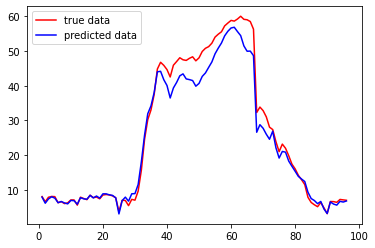

In [835]:
plot_validate_data(18)